<a href="https://colab.research.google.com/github/nirb28/nn_catalyst/blob/main/src/pl/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def resolve_path_gdrive(relativePath, localPathPrefix=""):
    if os.path.exists('/content/drive'):
        return '/content/drive/MyDrive/work/gdrive-workspaces/git/nn_catalyst/' + relativePath
    else:
        return localPathPrefix + relativePath
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np, os

# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the dataset from the csv file.
df_orig = pd.read_csv(resolve_path_gdrive('src/pl/merged_data_last29.csv', localPathPrefix="../"))

In [5]:
# prompt: standard scale all columns of df

import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = df_orig.copy()
for column in df.columns:
  if pd.api.types.is_numeric_dtype(df[column]):
    df[column] = scaler.fit_transform(df[[column]])



In [6]:
target_col_name = 'dipole_n'

print(df.shape)
df_features = df.drop(target_col_name, axis=1)
df_target = df[target_col_name]
print(df_features.shape)

(26233, 1508)
(26233, 1507)


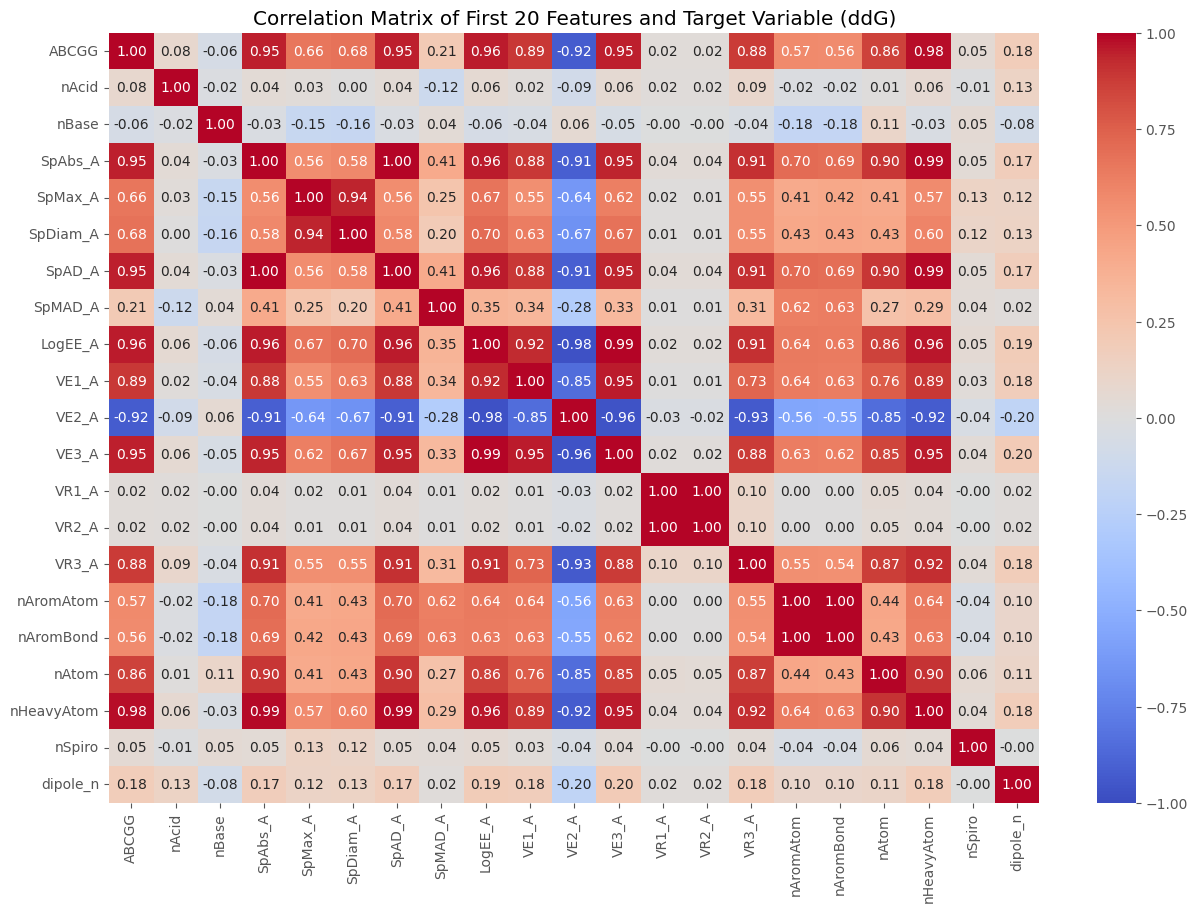

In [7]:
# Compute the correlation matrix for the first 20 features and the target variable to keep it manageable
correlation_matrix = df.iloc[:, 1:21].join(df[target_col_name]).corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of First 20 Features and Target Variable (ddG)")
plt.show()

In [9]:
corr_table = df_features.corrwith(df_target)
# prompt: find rows in corr_table where corr > .5
high_corr_rows = corr_table[abs(corr_table) > .2]
print(len(high_corr_rows.keys()))
high_corr_rows.keys()

95


Index(['nHetero', 'nN', 'nO', 'ATS0dv', 'ATS1s', 'ATSC0c', 'ATSC0dv', 'ATSC0s',
       'AATSC0dv', 'GATS1dv', 'GATS2dv', 'GATS1s', 'GATS2s', 'GATS3s',
       'GATS1se', 'GATS2se', 'GATS1pe', 'GATS2pe', 'GATS1are', 'GATS2are',
       'BCUTc-1h', 'BCUTdv-1h', 'BCUTs-1h', 'BCUTv-1l', 'BCUTse-1h',
       'BCUTp-1l', 'VE2_DzZ', 'VE2_Dzm', 'VE2_Dzv', 'VE2_Dzse', 'VE2_Dzpe',
       'VE2_Dzare', 'VE2_Dzp', 'VE2_Dzi', 'BertzCT', 'nBondsD', 'PNSA3',
       'PNSA5', 'PPSA1', 'PPSA2', 'PPSA3', 'PPSA4', 'PPSA5', 'DPSA2', 'DPSA3',
       'DPSA4', 'DPSA5', 'FPSA2', 'WNSA3', 'WNSA5', 'WPSA1', 'WPSA3', 'WPSA4',
       'WPSA5', 'TPSA', 'RASA', 'RPSA', 'VE2_D', 'NdO', 'SdO', 'ETA_beta',
       'ETA_eta_F', 'AETA_eta_F', 'ETA_eta_FL', 'GRAVp', 'nHBAcc', 'IC0',
       'IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'TIC0', 'TIC1', 'PEOE_VSA2',
       'PEOE_VSA13', 'EState_VSA8', 'VSA_EState2', 'VSA_EState3', 'MID_h',
       'MID_N', 'MID_O', 'AMID_O', 'piPC1', 'piPC2', 'piPC3', 'piPC6',
       'TopoPSA(NO)', 'TopoPSA',

In [10]:
f = open(resolve_path_gdrive("high_corr_cols.txt"), "w")
for key in high_corr_rows.keys():
  f.write('{},'.format(key))
f.close()

## PCA
Here we implement methods that reduce the number of parameters


In [11]:
## Use all columns except target
#X = df.drop([target_col_name], axis=1)
X = df[df.columns[:-29]]
## Use high correlation columns only
#X = df[high_corr_rows.keys()]
y = df[target_col_name]

# import libraires needed to perform our Regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

pca = PCA()
## Performing PCA on high_corr_keys
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

## Cumulative sum of variance explained by principal components
cumsum = np.cumsum(pca.explained_variance_ratio_)
pca_dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is', pca_dim)

[2.42519687e-01 8.33019255e-02 5.07722906e-02 ... 2.38148280e-33
 2.38148280e-33 8.43937353e-34]
The number of dimensions required to preserve 90% of variance is 117


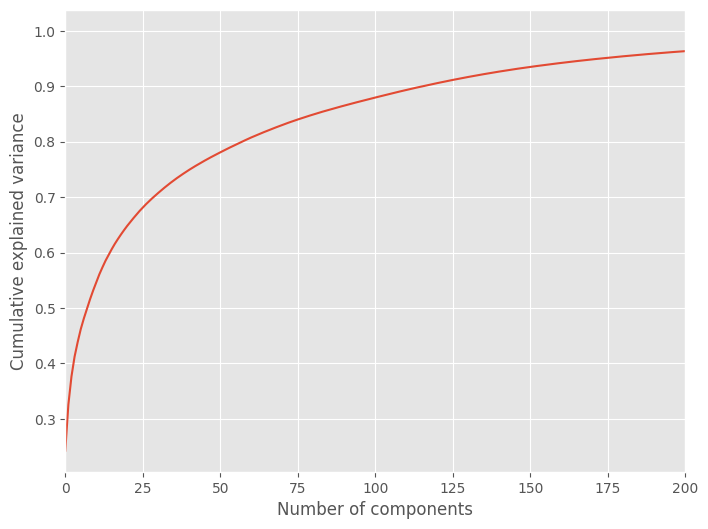

In [12]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,200,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [13]:
pca = PCA(n_components=pca_dim)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.24251969 0.08330193 0.05077229 0.03558399 0.02627966 0.02345396
 0.01933022 0.01751478 0.01707619 0.01583017 0.01475092 0.01436413
 0.01262482 0.0119852  0.01044776 0.01038765 0.00957329 0.00871007
 0.00829821 0.00787686 0.00751714 0.0070249  0.00681548 0.00664483
 0.00641224 0.00593762 0.00583416 0.00547177 0.00525016 0.0050164
 0.00490062 0.00479165 0.00467591 0.00455649 0.00433095 0.00426212
 0.00402851 0.0039535  0.00377033 0.00370649 0.00364173 0.00348348
 0.00338847 0.00328168 0.00322028 0.00319204 0.0031193  0.00301354
 0.00297886 0.00289129 0.00286801 0.00284602 0.00282348 0.00277532
 0.00270286 0.00268974 0.0026741  0.00264082 0.00261326 0.00257816
 0.00252287 0.00239575 0.00238445 0.00232817 0.00229495 0.00224503
 0.00223837 0.0021984  0.00216116 0.00212723 0.00209079 0.00207609
 0.00204492 0.00198534 0.00194625 0.00187034 0.00185701 0.00182363
 0.00179637 0.001785   0.00175642 0.00172718 0.00168502 0.00166009
 0.00160575 0.00160372 0.00158565 0.00156453 0.00154759 0.00153

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X_pca,y,test_size=0.2)
for i in [X_train,X_test,y_train,y_test]:
    print("Shape of Data is {}".format(i.shape))

Shape of Data is (20986, 117)
Shape of Data is (5247, 117)
Shape of Data is (20986,)
Shape of Data is (5247,)


In [15]:
from sklearn.cross_decomposition import PLSRegression
model = PLSRegression(n_components=pca_dim)
# fitting the model
model.fit(X_train, y_train)

# making predictions
y_pred = model.predict(X_test)

r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('R2 Score is : {} | Root Mean Square Error is : {}'.format(r2,rmse))

R2 Score is : 0.18019701353154516 | Root Mean Square Error is : 0.9061140488206775


In [16]:
## Testing our model
tmp_df = y_test.to_frame()
tmp_df['pred'] = y_pred.tolist()
tmp_df

,dipole_n,pred
213,-0.315036,0.713160
1908,-0.480365,0.944523
12801,-0.187623,-0.272661
21516,1.316300,0.225656
19657,0.232095,0.242493
...,...,...
14612,1.207061,0.450205
3827,0.337528,0.251350
3978,0.129607,0.108458
4064,-0.648851,-0.294022


In [ ]:
# prompt: add polynomial regression to the above code

import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# ... (Your existing code) ...

# Create polynomial features
poly = PolynomialFeatures(degree=2)  # You can adjust the degree as needed
X_poly = poly.fit_transform(X_pca)

# Split data into training and testing sets with polynomial features
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2)

# Create and train a linear regression model using polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train_poly)

# Make predictions using the polynomial regression model
y_pred_poly = model_poly.predict(X_test_poly)

# Evaluate the polynomial regression model
r2_poly = r2_score(y_test_poly, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test_poly, y_pred_poly))

print('Polynomial Regression:')
print('R2 Score is : {} | Root Mean Square Error is : {}'.format(r2_poly, rmse_poly))



In [ ]:
from joblib import dump, load
dump(model, resolve_path_gdrive('models/pls_large.joblib'))
clf2 = load(resolve_path_gdrive('models/pls_large.joblib'))

In [ ]:
df_pred = df[1:5]
X_pred = df_pred[high_corr_rows.keys()]
y_pred = df_pred['ddG']
y_pred2 = clf2.predict(X_pred)

In [ ]:
tmp_df = y_pred.to_frame()
tmp_df['pred'] = y_pred2.tolist()
tmp_df

,ddG,pred
1,0.719002,[1.0918201102818612]
10,0.631877,[0.5847719015935183]
16,0.216792,[0.2587352704606415]
17,0.111677,[0.2587352704606415]


In [ ]:
y_pred2 = clf2.predict(X_pred.iloc[2].to_numpy().reshape(1,-1))

C:\work\workspaces\python\miniconda3\envs\ml2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


In [ ]:
X = df[df.columns[~df.columns.isin(['Catalyst', 'ddG'])]] # high_corr_rows.keys() OR df.columns[~df.columns.isin(['Catalyst', 'ddG'])]
y = df['ddG']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
for i in [X_train,X_test,y_train,y_test]:
    print("Shape of Data is {}".format(i.shape))

from sklearn.linear_model import Lasso

model = Lasso(alpha=0.0001)
model.fit(X_train, y_train)

# making predictions
y_pred = model.predict(X_test)

r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('R2 Score is : {} | Root Mean Square Error is : {}'.format(r2,rmse))

Shape of Data is (255, 3974)
Shape of Data is (64, 3974)
Shape of Data is (255,)
Shape of Data is (64,)
R2 Score is : 0.5785562854353197 | Root Mean Square Error is : 0.3031214099054295


In [ ]:
X = df[df.columns[~df.columns.isin(['Catalyst', 'ddG'])]] # high_corr_rows.keys() OR df.columns[~df.columns.isin(['Catalyst', 'ddG'])]
y = df['ddG']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
for i in [X_train,X_test,y_train,y_test]:
    print("Shape of Data is {}".format(i.shape))

# Lets train our model on training data and predict also on training to see results
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_train)
r2 = r2_score(y_train,y_pred)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
print('R-Squared Score is : {} | Root Mean Square Error is : {}'.format(r2,rmse))

Shape of Data is (255, 3974)
Shape of Data is (64, 3974)
Shape of Data is (255,)
Shape of Data is (64,)
R-Squared Score is : 0.8856918964763432 | Root Mean Square Error is : 0.1407639594970315


In [ ]:
# Lets train our model on training data and predict on testing to see results
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('R2 Score is : {} | Root Mean Square Error is : {}'.format(r2,rmse))

R2 Score is : -4.065145957139249e+20 | Root Mean Square Error is : 8660800427.264627


## Subset Selection Methods
Here we implement methods that reduce the number of parameters

### Forward Selection
We will  apply the forward-selection approach


In [ ]:
!pip install ISLP
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

0

In [ ]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [ ]:
df_cleaned.head()

,1,2,3,4,5,6,7,8,9,10,...,3965,3966,3967,3968,3969,3970,3971,3972,3973,ddG
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.833714,-0.605952,-0.471700,-0.768480,-0.178536,-0.298590,-0.238640,-0.277510,-0.230633,-0.672194
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880495,-0.602624,-0.471616,-0.798242,-0.277709,-0.280445,-0.279338,-0.246094,-1.153164,-1.146684
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.104378,1.789966,1.707972,-0.078629,-1.416062,-1.347984,-1.383415,0.492188,0.691898,0.276786
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.938972,-0.643031,-0.505083,-0.825677,-0.297732,-0.236059,-0.267225,0.028798,-0.691898,-0.672194
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.112732,0.601039,0.691527,1.360684,0.614598,0.524781,0.570340,-1.518452,-0.230633,1.463011


We first choose the best model using forward selection based on $C_p$. We define a function to compute it as its not built in as a metric to `sklearn`. By default, `sklearn` tries to maximize a score, hence
  our scoring function  computes the negative $C_p$ statistic.

In [ ]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n


In [ ]:
design = MS(df_cleaned.columns.drop('ddG')).fit(df_cleaned)
Y = np.array(df_cleaned['ddG'])
X = design.transform(df_cleaned)
sigma2 = OLS(Y,X).fit().scale

In [ ]:
neg_Cp = partial(nCp, sigma2)

We can now use `neg_Cp()` as a scorer for model selection.

Along with a score we need to specify the search strategy. This is done through the object
`Stepwise()`  in the `ISLP.models` package. The method `Stepwise.first_peak()`
runs forward stepwise until any further additions to the model do not result
in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()`
runs a fixed number of steps of stepwise search.

In [ ]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))


We now fit a linear regression model with `Salary` as outcome using forward
selection. To do so, we use the function `sklearn_selected()`  from the `ISLP.models` package. This takes
a model from `statsmodels` along with a search strategy and selects a model with its
`fit` method. Without specifying a `scoring` argument, the score defaults to MSE, and so all 19 variables will be
selected.

In [ ]:
hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(df_cleaned, Y)
hitters_MSE.selected_state_


('3954', '3955', '3964', '3968', '3970')

Using `neg_Cp` results in a smaller model, as expected, with just 10 variables selected.

In [ ]:
hitters_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
hitters_Cp.fit(df_cleaned, Y)
hitters_Cp.selected_state_


('2595', '3489', '3955', '3960', '3964', '3968', '3970')

### Choosing Among Models Using the Validation Set Approach and Cross-Validation

As an  alternative to using $C_p$, we might try cross-validation to select a model in forward selection. For this, we need a
method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()`
estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models`
computes the cross-validated predictions for each of the models
along the path, which we can use to evaluate the cross-validated MSE
along the path.

Here we define a strategy that fits the full forward selection path.
While there are various parameter choices for `sklearn_selection_path()`,
we use the defaults here, which selects the model at each step based on the biggest reduction  in RSS.

In [ ]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)


We now fit the full forward-selection path on the `Hitters` data and compute the fitted values.

In [ ]:
full_path.fit(df_cleaned, Y)
Yhat_in = full_path.predict(df_cleaned)
Yhat_in.shape


This gives us an array of fitted values --- 20 steps in all, including the fitted mean for the null model --- which we can use to evaluate
in-sample MSE. As expected, the in-sample MSE improves each step we take,
indicating we must use either the validation or cross-validation
approach to select the number of steps. We fix the y-axis to range from
50,000 to 250,000 to compare to the cross-validation and validation
set MSE below, as well as other methods such as ridge regression, lasso and
principal components regression.

In [ ]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)